In [1]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import random
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from scipy.ndimage import rotate

np.random.seed(3)
random.seed(3)
torch.manual_seed(3)
torch.cuda.manual_seed(3)

In [2]:
#Считываем данные
df_train = pd.read_csv('train.csv', dtype = np.float32)
df_test = pd.read_csv('test.csv', dtype = np.float32)
df_train.shape, df_test.shape

((42000, 785), (28000, 784))

In [3]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


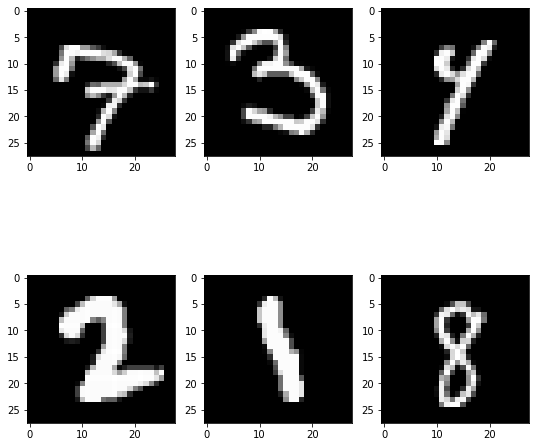

In [4]:
#Посмотрим на то, как выглядят изображения
fig, axs = plt.subplots(2, 3, figsize = (9, 9))
axs[0, 0].imshow(df_test.loc[5, :].to_numpy().reshape(28, 28), cmap = 'gray')
axs[0, 1].imshow(df_test.loc[16, :].to_numpy().reshape(28, 28), cmap = 'gray')
axs[0, 2].imshow(df_test.loc[28, :].to_numpy().reshape(28, 28), cmap = 'gray')
axs[1, 0].imshow(df_test.loc[35, :].to_numpy().reshape(28, 28), cmap = 'gray')
axs[1, 1].imshow(df_test.loc[38, :].to_numpy().reshape(28, 28), cmap = 'gray')
axs[1, 2].imshow(df_test.loc[46, :].to_numpy().reshape(28, 28), cmap = 'gray')

In [5]:
#Разделим на train и test
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['label'], axis = 1), df_train['label'],
                                                   test_size = 0.2, shuffle = True, stratify = df_train['label'])

In [6]:
#Переведем данные в тензоры
X_train = torch.Tensor(X_train.to_numpy())
X_test = torch.Tensor(X_test.to_numpy())
y_train = torch.Tensor(y_train.to_numpy())
y_test = torch.Tensor(y_test.to_numpy())

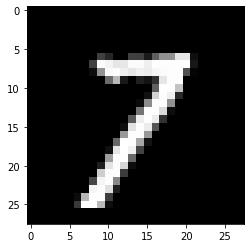

In [7]:
#Преобразуем в формат картинок 28 на 28 и посмотрим, все ли получилось верно, отрисовав картинку
X_train = X_train.reshape(len(X_train), 1, 28, 28)
X_test = X_test.reshape(len(X_test), 1, 28, 28)

plt.imshow(X_train[15,:].reshape(1, 28, 28)[0 , :, :], cmap = 'gray')

In [8]:
X_train.shape, X_test.shape

(torch.Size([33600, 1, 28, 28]), torch.Size([8400, 1, 28, 28]))

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.first_block = nn.Sequential(
                                      
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1),
            nn.InstanceNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)

        )

        self.second_block = nn.Sequential(

            nn.Linear(7*7*128, 2048),
            nn.BatchNorm1d(num_features = 2048),
            nn.ReLU(),
            nn.Dropout(p = 0.3),

            nn.Linear(2048, 1024),
            nn.BatchNorm1d(num_features = 1024),
            nn.ReLU(),
            nn.Dropout(p = 0.3),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(num_features = 512),
            nn.ReLU(),
            nn.Dropout(p = 0.3),

            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.first_block(x)
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.second_block(x)
        return x

net = Net()

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

In [11]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 1.0e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode = 'max',
                                                       patience = 10,
                                                       verbose = True,
                                                       factor = 0.5, min_lr=0.0001)

In [12]:
y_train = y_train.type(torch.LongTensor)
y_test = y_test.type(torch.LongTensor)

In [13]:
max_val = torch.Tensor([0.995]).to(device)
batch_size = 50
accuracy_test_hist = []

for epoch in range(300):
    
    order = np.random.permutation(len(X_train)) #генерируем случайные индексы
    
    for start_indexes in range(0, len(X_train), batch_size):
        
        optimizer.zero_grad()
        net.train()
        
        batch_indexes = order[start_indexes : start_indexes + batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        #шум, инверсия, поворот
        
        #добавляем случайный шум
        r = (torch.randn(X_batch.shape)*4)
        X_batch_rand = X_batch + torch.where((r>0), r, torch.Tensor([0])) #Зануляем отрицательные и прибавляем
        X_batch_new = torch.cat((X_batch, X_batch_rand), dim = 0) #Добавляем к батчу
        
        #Добавляем инверсию
        X_batch_invers = 255 - X_batch
        X_batch_new = torch.cat((X_batch_new, X_batch_invers), dim = 0)
        
        #Поворот
        X_batch_rotation = X_batch.clone()
        for n in range(0, len(X_batch)):
            X_batch_rotation[n] = torch.Tensor(rotate(X_batch_rotation[n].reshape(28, 28), angle = np.random.randint(-26, 26), reshape = False)).reshape(1, 28, 28)

        X_batch_new = torch.cat((X_batch_new, X_batch_rotation), dim = 0)
        
        X_batch_new = X_batch_new.to(device)

        preds = net.forward(X_batch_new)
        
        y_batch_new = torch.cat((y_batch, y_batch), dim = 0)
        y_batch_new = torch.cat((y_batch_new, y_batch), dim = 0)
        y_batch_new = torch.cat((y_batch_new, y_batch), dim = 0).to(device)

        loss_value = loss(preds, y_batch_new)
        loss_value.backward()

        optimizer.step()
        
    if(True):
        
        order_test = np.random.permutation(len(X_test))
        accuracy = 0
        net.eval()
        
        for start_test in range(0, len(X_test), batch_size):

            batch_indexes_test = order_test[start_test : start_test + batch_size]
            
            X_test_batch = X_test[batch_indexes_test].to(device)
            y_test_batch = y_test[batch_indexes_test].to(device)
            
            test_preds = net.forward(X_test_batch)
            accuracy += (test_preds.argmax(dim = 1) == y_test_batch).float().mean()

        
        accuracy = accuracy / (len(X_test)/batch_size)
        scheduler.step(accuracy)
        accuracy_test_hist.append(accuracy.data.cpu())

        if((accuracy >= max_val)):
            max_val = accuracy
            torch.save(net.state_dict(), "best_model.pth")
       
        
        print(accuracy)

tensor(0.9839, device='cuda:0')
tensor(0.9888, device='cuda:0')
tensor(0.9893, device='cuda:0')
tensor(0.9910, device='cuda:0')
tensor(0.9907, device='cuda:0')
tensor(0.9930, device='cuda:0')
tensor(0.9912, device='cuda:0')
tensor(0.9918, device='cuda:0')
tensor(0.9927, device='cuda:0')
tensor(0.9907, device='cuda:0')
tensor(0.9930, device='cuda:0')
tensor(0.9935, device='cuda:0')
tensor(0.9930, device='cuda:0')
tensor(0.9936, device='cuda:0')
tensor(0.9918, device='cuda:0')
tensor(0.9927, device='cuda:0')
tensor(0.9926, device='cuda:0')
tensor(0.9932, device='cuda:0')
tensor(0.9932, device='cuda:0')
tensor(0.9933, device='cuda:0')
tensor(0.9951, device='cuda:0')
tensor(0.9937, device='cuda:0')
tensor(0.9944, device='cuda:0')
tensor(0.9942, device='cuda:0')
tensor(0.9943, device='cuda:0')
tensor(0.9948, device='cuda:0')
tensor(0.9935, device='cuda:0')
tensor(0.9950, device='cuda:0')
tensor(0.9939, device='cuda:0')
tensor(0.9944, device='cuda:0')
tensor(0.9946, device='cuda:0')
tensor(0

KeyboardInterrupt: 

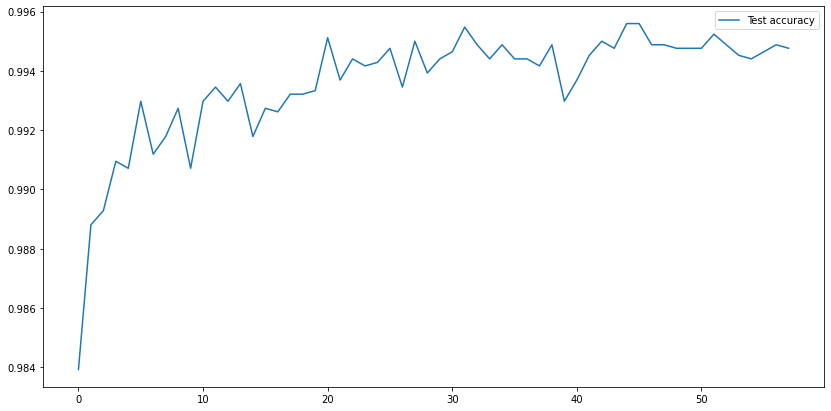

In [14]:
plt.figure(figsize = (14, 7))
plt.plot(accuracy_test_hist, label = 'Test accuracy')
plt.legend()
plt.show()

In [15]:
net.load_state_dict(torch.load("best_model.pth"))
net = net.to(device)
print(max_val)

tensor(0.9956, device='cuda:0')


In [16]:
X_testing = torch.Tensor(df_test.to_numpy())
X_testing = X_testing.reshape(len(X_testing), 1, 28, 28)
X_testing = X_testing.to(device)

In [17]:
ans = np.array([])
net.eval()
for i in range(0, len(df_test)):
    preds = net.forward(X_testing[i:i+1])
    preds = preds.argmax(dim = 1)
    preds = preds.to('cpu')
    preds = preds.detach().numpy()
    
    ans = np.append(ans, preds)

In [18]:
preds2 = pd.Series(ans.astype('int'),name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"), preds2],axis = 1)
submission.to_csv("answer.csv",index=False)

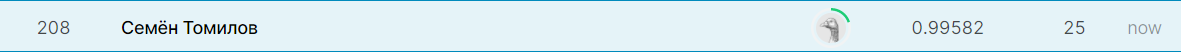